#  [German Traffic Sign Recognition Benchmark](http://benchmark.ini.rub.de/)

![](./input/gts.jpeg)

In [10]:
import pickle

import numpy as np
np.random.seed(2017)
import pandas as pd

from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization, Activation
from keras.utils import to_categorical
from keras.optimizers import Adam

from skimage import color, exposure

from tqdm import tqdm

import matplotlib.pyplot as plt
from matplotlib.figure import Figure

from collections import Counter

%matplotlib inline

### Load data

In [5]:
training_file = "./input/train.p"
test_file     =  "./input/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)

with open(test_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

print(X_train.shape, X_test.shape)

(34799, 32, 32, 3) (4410, 32, 32, 3)


### Load label descriptions

In [7]:
signnames = pd.read_csv('./input/signnames.csv')
signnames.head(50)

,a,b
0,0,Speed limit (20km/h)
1,1,Speed limit (30km/h)
2,2,Speed limit (50km/h)
3,3,Speed limit (60km/h)
4,4,Speed limit (70km/h)
5,5,Speed limit (80km/h)
6,6,End of speed limit (80km/h)
7,7,Speed limit (100km/h)
8,8,Speed limit (120km/h)
9,9,No passing


### Data preparation

In [9]:
if y_train.ndim == 1: y_train = to_categorical(y_train)
if y_test.ndim == 1: y_test = to_categorical(y_test)    
    
input_shape = X_train.shape[1:]

traffic_labels_dict = signnames[ ['b'] ].to_dict()['b']
num_classes = len(traffic_labels_dict)

## Preparing model

In [14]:
def doubled_cnn3_with_bn():
    model = Sequential()
    
    model.add(Conv2D(32, kernel_size=(3, 3), padding='same', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Activation('relu'))   
    model.add(Conv2D(32, kernel_size=(3, 3)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
        
    model.add(Conv2D(64, kernel_size=(3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(64, kernel_size=(3, 3)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
        
    model.add(Conv2D(128, kernel_size=(3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(128, kernel_size=(3, 3)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
        
    model.add(Flatten())
        
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(num_classes, activation='softmax'))
    return model


model = doubled_cnn3_with_bn()
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_13 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
activation_13 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 30, 30, 32)        9248      
_________________________________________________________________
batch_normalization_14 (Batc (None, 30, 30, 32)        128       
_________________________________________________________________
activation_14 (Activation)   (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 15, 15, 32)        0         
__________

### Training

In [15]:
history = model.fit(X_train, y_train,
          batch_size=128,
          epochs=4,
          verbose=1,
          validation_data=(X_test, y_test))

Train on 34799 samples, validate on 4410 samples
Epoch 1/4
34799/34799 [==============================] - 770s 22ms/step - loss: 1.4601 - acc: 0.5881 - val_loss: 0.4347 - val_acc: 0.8469
Epoch 2/4
34799/34799 [==============================] - 525s 15ms/step - loss: 0.2038 - acc: 0.9389 - val_loss: 0.1229 - val_acc: 0.9610
Epoch 3/4
34799/34799 [==============================] - 515s 15ms/step - loss: 0.0958 - acc: 0.9708 - val_loss: 0.0998 - val_acc: 0.9689
Epoch 4/4
34799/34799 [==============================] - 633s 18ms/step - loss: 0.0540 - acc: 0.9841 - val_loss: 0.0981 - val_acc: 0.9787


### Testing

In [16]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

print("CNN Error: %.2f%%" % (100-score[1]*100))

Test loss: 0.0980620920706
Test accuracy: 0.978684807256
CNN Error: 2.13%


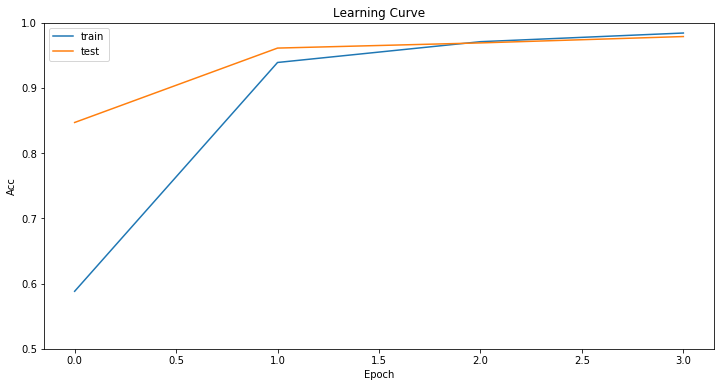

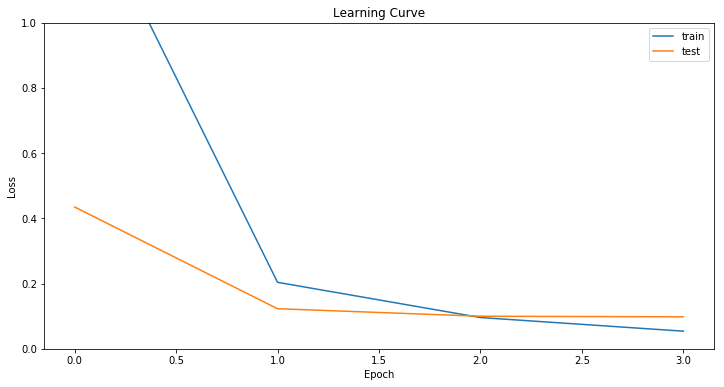

In [17]:
def draw_learning_curve(history, key='acc', ylim=(0.8, 1.01)):
    plt.figure(figsize=(12,6))
    plt.plot(history.history[key])
    plt.plot(history.history['val_' + key])
    plt.title('Learning Curve')
    plt.ylabel(key.title())
    plt.xlabel('Epoch')
    plt.ylim(ylim)
    plt.legend(['train', 'test'], loc='best')
    plt.show()
    
draw_learning_curve(history, key='acc', ylim=(0.5, 1.))
draw_learning_curve(history, key='loss', ylim=(0., 1.))